In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [47]:
crimes_2012 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', sep=',', error_bad_lines=False)
# crimes_2012.drop(crimes_2012.columns[[0, 2, 5]], axis=1)

### preprocessing

In [48]:
crimes_2012.apply(lambda x: sum(x.isnull()))
crimes_2012.apply(lambda x: len(x.unique()))

Unnamed: 0              1456714
ID                      1456714
Case Number             1456599
Date                     582146
Block                     32774
IUCR                        365
Primary Type                 33
Description                 342
Location Description        143
Arrest                        2
Domestic                      2
Beat                        302
District                     25
Ward                         51
Community Area               79
FBI Code                     26
X Coordinate              67715
Y Coordinate             111556
Year                          6
Updated On                  959
Latitude                 368077
Longitude                367943
Location                 368287
dtype: int64

In [45]:
crimes_2012.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimes_2012.drop(['Unnamed: 0','Case Number','IUCR','FBI Code','Updated On','Location',
                  'X Coordinate','Y Coordinate','Location'], inplace = True, axis = 1)
crimes_2012 = crimes_2012.dropna(axis = 0, how = 'any')

## date conversion
crimes_2012.Date = pd.to_datetime(crimes_2012.Date, format = '%m/%d/%Y %I:%M:%S %p')
crimes_2012.index = pd.DatetimeIndex(crimes_2012.Date)

In [38]:
crimes_2012['Primary Type'] = pd.Categorical(crimes_2012['Primary Type'])
crimes_2012['Description'] = pd.Categorical(crimes_2012['Description'])
crimes_2012['Location Description'] = pd.Categorical(crimes_2012['Location Description'])

### EDA

let's visualize different types of crimes per month

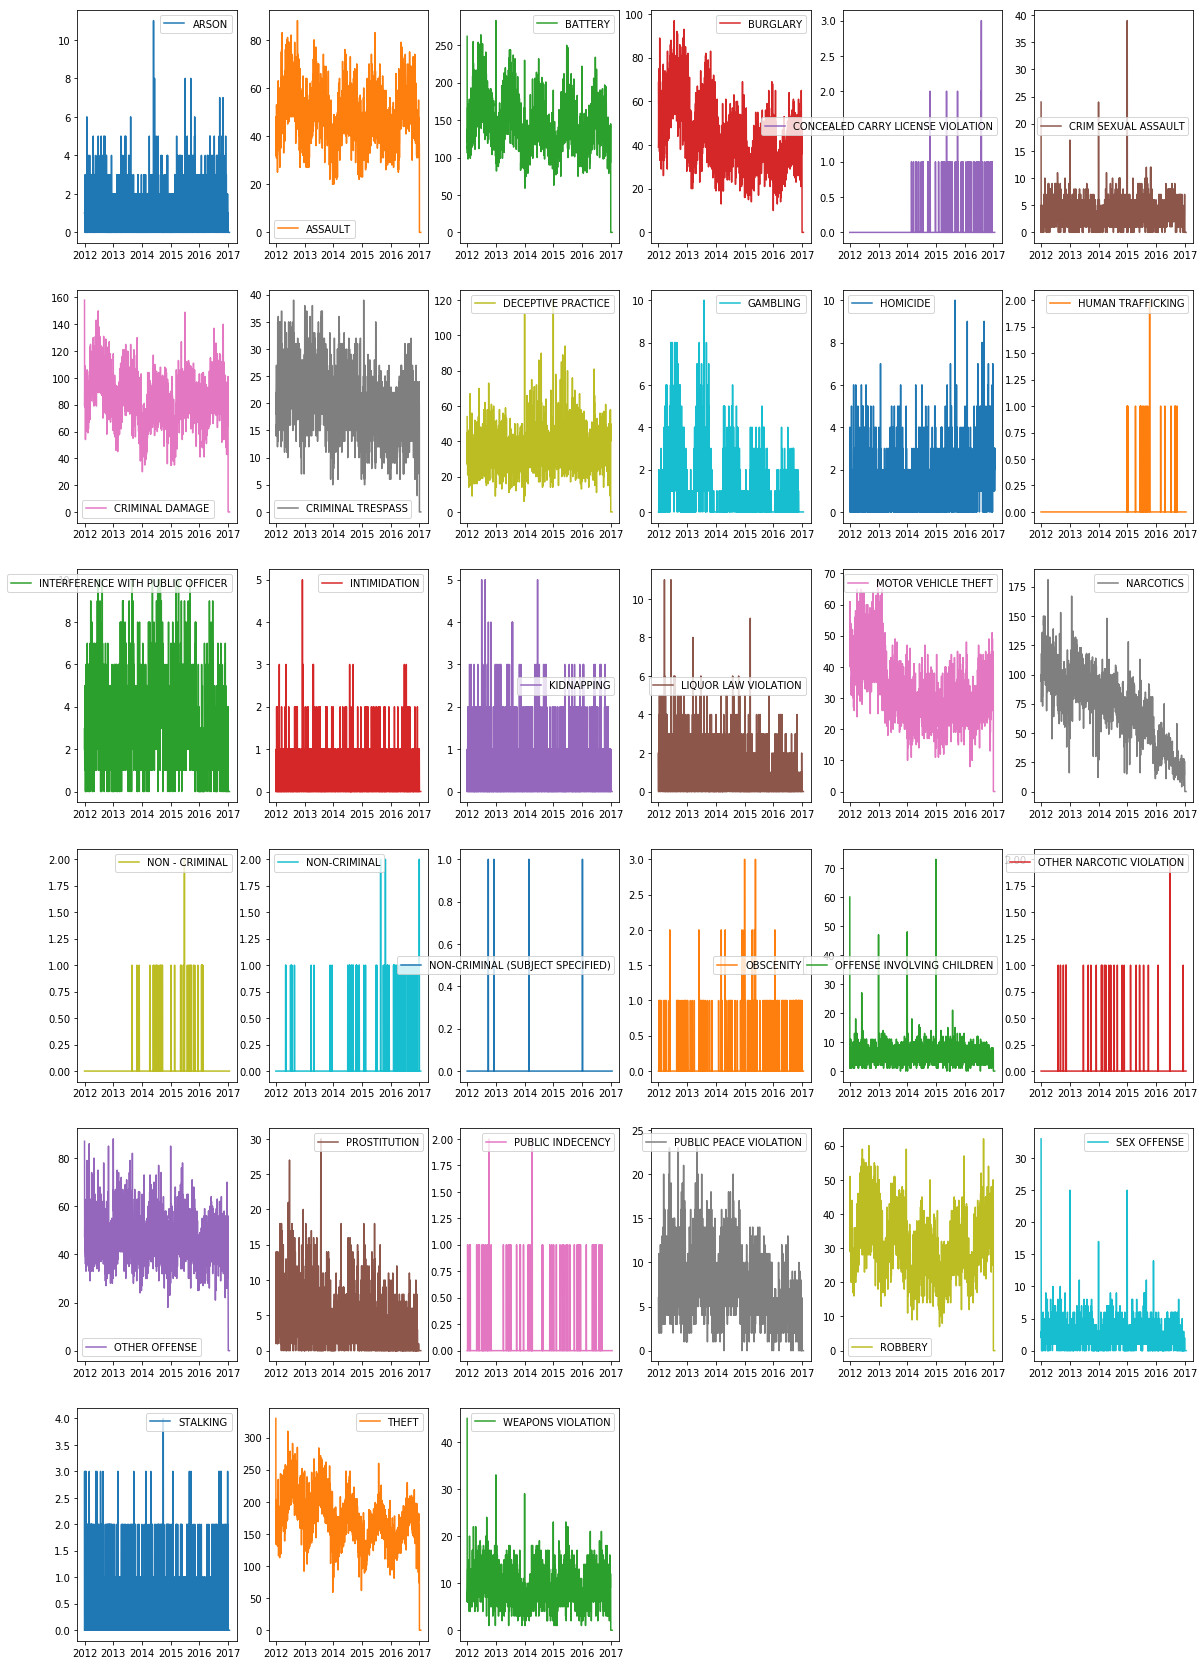

In [39]:
Crime_Data_date = crimes_2012.pivot_table('ID', aggfunc = np.size, columns = 'Primary Type', 
                                         index = crimes_2012.index.date, fill_value = 0)
Crime_Data_date.index = pd.DatetimeIndex(Crime_Data_date.index)

Plot = Crime_Data_date.plot(figsize = (20,30), subplots = True, layout = (6,6),
                                  sharex = False, sharey = False)
plt.show()

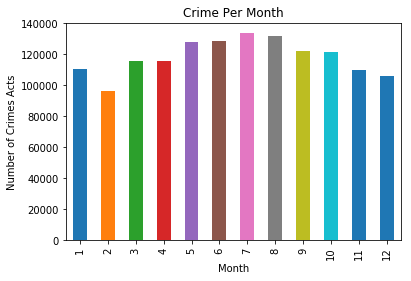

In [40]:
#make graph of crimes per month
crimes_2012.groupby([crimes_2012.index.month]).size().plot.bar()
plt.title('Crime Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Acts')
plt.show()

"\n#plot of the relatives amounts of each type of crime\nplt.figure(figsize = (8,12))\ncrimes_2012.groupby(crimes_2012['Primary Type']).size().sort_values(ascending = True).plot(kind = 'barh')\nplt.xlabel('Number of Crimes Committed')\nplt.show()\n"

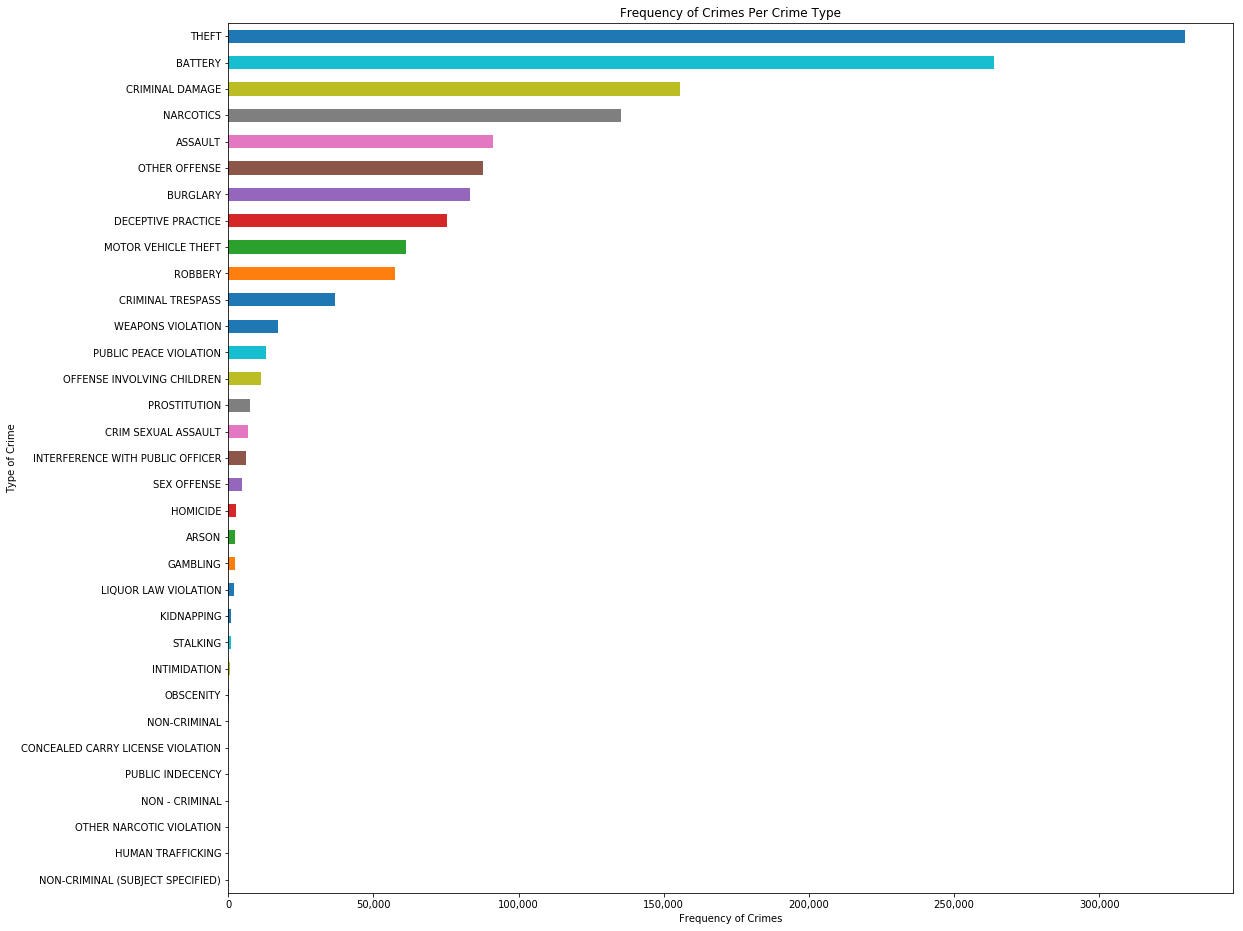

In [52]:
## most prevalent crimes that occured in Chicago

crime_type_df = crimes_2012['Primary Type'].value_counts(ascending=True)

## Some formatting to make it look nicer
fig=plt.figure(figsize=(18, 16))
plt.title("Frequency of Crimes Per Crime Type")
plt.xlabel("Frequency of Crimes")
plt.ylabel("Type of Crime")
ax = crime_type_df.plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


"""
#plot of the relatives amounts of each type of crime
plt.figure(figsize = (8,12))
crimes_2012.groupby(crimes_2012['Primary Type']).size().sort_values(ascending = True).plot(kind = 'barh')
plt.xlabel('Number of Crimes Committed')
plt.show()
"""

In [49]:
#extract year data for each crime

"""
Groups = crimes_2012.groupby(crimes_2012['Primary Type'])
Groups = dict(list(Groups))
Keys = list(Groups.keys())

for key in Keys:
    plt.figure(figsize = (4,4))
    plt.scatter(Groups[key].Longitude, Groups[key].Latitude, marker = '.')
    plt.ylim(41.6,42.1)
    plt.xlim(-88,-87.4)
    plt.title(key)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()
"""


"\nGroups = crimes_2012.groupby(crimes_2012['Primary Type'])\nGroups = dict(list(Groups))\nKeys = list(Groups.keys())\n\nfor key in Keys:\n    plt.figure(figsize = (4,4))\n    plt.scatter(Groups[key].Longitude, Groups[key].Latitude, marker = '.')\n    plt.ylim(41.6,42.1)\n    plt.xlim(-88,-87.4)\n    plt.title(key)\n    plt.ylabel('Latitude')\n    plt.xlabel('Longitude')\n    plt.show()\n"

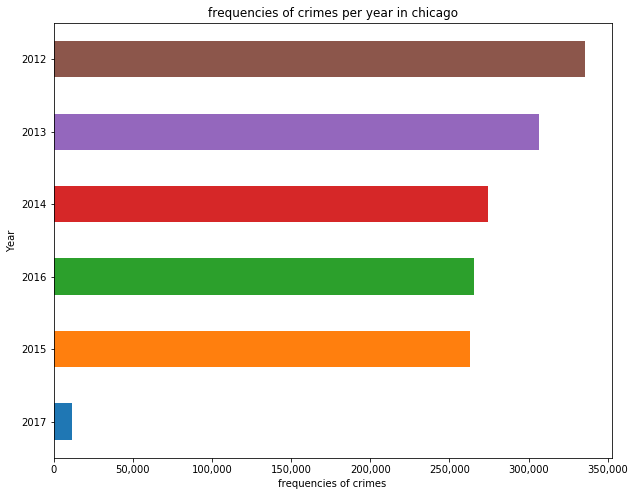

In [58]:
### crime in each year
crimes_2012['Year'].isnull().values.any()
crimes_2012['Year'].value_counts()

## visualize it

crimes_2012_by_year = crimes_2012['Year'].value_counts(ascending=True)
fig = plt.figure(figsize=(10,8))
plt.title("frequencies of crimes per year in chicago")
plt.xlabel("frequencies of crimes")
plt.ylabel("Year")
ax=crimes_2012_by_year.plot(kind="barh")
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


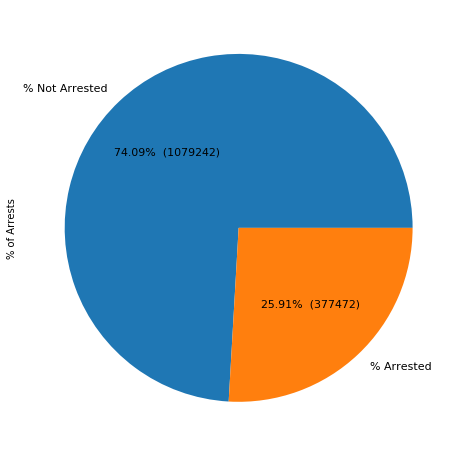

In [74]:
## visualize successful arrest type

crimes_2012['Arrest'].isnull().values.any()

arrest_df = crimes_2012['Arrest'].value_counts()
arrest_percent = (arrest_df / crimes_2012['Arrest'].sum()) * 100 
arrest_percent.rename("% of Arrests",inplace=True)
arrest_percent.rename({True: '% Arrested', False: '% Not Arrested'},inplace=True)


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

## show it with pieplot
arrest_percent.plot.pie(fontsize=11,
                       autopct=make_autopct(crimes_2012['Arrest'].value_counts()), figsize=(8, 8))

In [76]:
## Group dataset by year and arrests
arrest_per_year = crimes_2012.groupby('Year')['Arrest'].value_counts().rename('Counts').to_frame()
arrest_per_year['Percentage'] = (100 * arrest_per_year / arrest_per_year.groupby(level=0).sum())
arrest_per_year.reset_index(level=[1],inplace=True)

arrest_per_year.head()

,Arrest,Counts,Percentage
Year,,,
2012,False,245159,73.035720
2012,True,90511,26.964280
2013,False,220484,71.888439
2013,True,86219,28.111561
2014,False,195470,71.202468


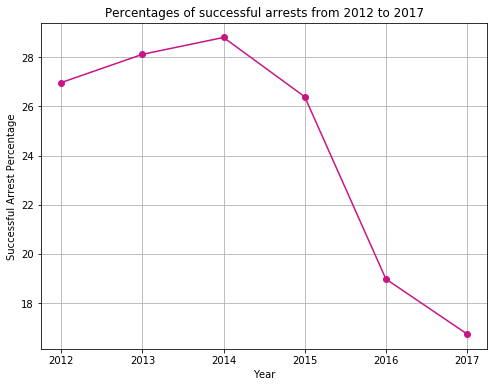

In [80]:
## Create a line plot for percentages of successful arrests over time (2001 to present)
line_plot = arrest_per_year[arrest_per_year['Arrest'] == True]['Percentage']

## Configure line plot to make visualizing data cleaner
labels = line_plot.index.values
fig=plt.figure(figsize=(8, 6))
plt.title('Percentages of successful arrests from 2012 to 2017')
plt.xlabel("Year")
plt.ylabel("Successful Arrest Percentage")
plt.xticks(line_plot.index, line_plot.index.values)

line_plot.plot(grid=True, marker='o', color='mediumvioletred')
